In [1]:
## conda requirements
# !conda install --file ../env/byoml_sklearn.environment.yml
# !conda activate byoml_sklearn 
# !pip install -r ../env/byoml_sklearn.requirements.txt
## pip-only requirements:
# !pip install waylay-beta scikit-learn==0.22 seaborn tenacity

In [2]:
from datetime import datetime
from random import random
run_id = f"{datetime.now():%Y-%m-%d}-{1000 * random():04.0f}"
MODEL_NAME=f'tutorial-{run_id}'
MODEL_NAME

'tutorial-2021-05-04-0539'

In this notebook we will show how you can integrate a scikit-learn model with our platform. We will make use of our Python SDK, which you can install by executing: 

`pip install waylay-beta`

This demo depends on some additional libraries:

`pip install scikit-learn==0.22 seaborn tenacity`

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt

## Generated dataset

First let's create a dataset generator for a temperature and light sensor consisting of 
* three gaussian blobs with fixed sized around fixed centers 
* a uniform scattering of data, the candidate outliers. 

In [4]:
col_tmp = 'Temperature'
col_amb = 'Light Ambience'
col_src = 'Source'
col_features = [col_tmp, col_amb]

def generate_dataset(samples=300, outliers=0.1):
    blob_data =  make_blobs(
        centers=[[16, 0], [21, 1200], [19, 600]], 
        cluster_std=[[1, 0], [0.5, 150], [0.7, 180]], 
        n_features=2, 
        n_samples=samples
    )
    dataset_blob = pd.DataFrame(blob_data[0], columns=[col_tmp, col_amb])
    dataset_blob[col_src] = 'blob'

    outlier_count = int(outliers * samples)
    outlier_data = np.random.uniform(low=[13, 0], high=[24, 2000], size=(outlier_count,2))
    dataset_outliers = pd.DataFrame(outlier_data, columns=[col_tmp, col_amb])
    dataset_outliers[col_src] = 'uniform'
    
    return dataset_blob.append(dataset_outliers, ignore_index=True).sample(n=samples)



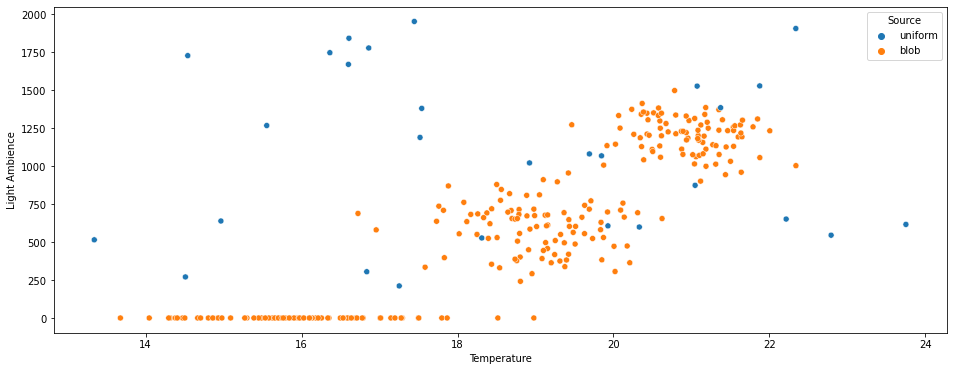

In [5]:
dataset_train = generate_dataset(outliers=0.1)
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x=col_tmp, y=col_amb, hue=col_src, data=dataset_train)


## Create a model

In this example we will use an IsolationForest to detect outliers, for which later on alarms can be generated.

In [6]:
from sklearn.ensemble import IsolationForest

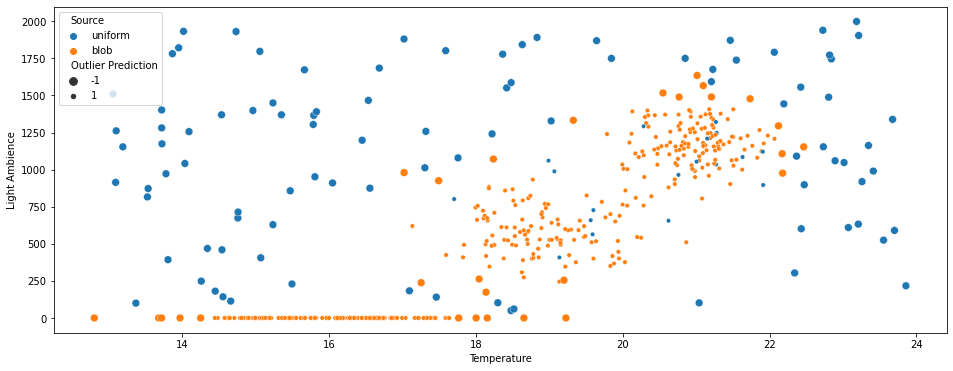

In [7]:
# we use the knowledge that 0.1 of the datapoints are expected to be outliers
model = IsolationForest(contamination=0.1)
model.fit(dataset_train[col_features])

# you could try other sample counts and outlier proportions here ...
dataset_validate = generate_dataset(samples=500, outliers=0.3)
col_predict = 'Outlier Prediction'
dataset_predict = dataset_validate.copy()
dataset_predict[col_predict] = model.predict(dataset_validate[col_features])

plt.figure(figsize=(16, 6))
ax = sns.scatterplot(
    x=col_tmp, y=col_amb,
    hue=col_src, 
    size=col_predict, sizes=[60,20], 
    data=dataset_predict
)

Let's have a look of the performance of this model. 

The sklearn `confusion_matrix` will count expected predictions (whether the datapoint came from the _uniform_ or _blob_ distributions), with the actual classification by the model.

Of course we expect quite some _false negative_ classifications, where samples from the _uniform_ distribution happen to be consistent with the _blobs_.

In [8]:
def report(dataset_predict):
    expected = dataset_predict[col_src].map(lambda x: 1 if x=='blob' else -1)
    predicted = dataset_predict[col_predict]
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
    display(pd.DataFrame(
        confusion_matrix(expected, predicted),
        columns=['Detected', 'Not Detected'],
        index=['Uniform', 'Blob']
    ))
    display(pd.DataFrame(
        [
            precision_score(expected,predicted),
            recall_score(expected,predicted),
            f1_score(expected,predicted)
        ],
        columns=['Score'],
        index=['Precision', 'Recall', 'F1']
    ))

report(dataset_predict)

,Detected,Not Detected
Uniform,95,18
Blob,28,359


,Score
Precision,0.952255
Recall,0.927649
F1,0.939791


## Upload and test the model

When the model is ready, we can upload it to the platform. First we need to save it, afterwards we can use the SDK to upload and call it. 
When uploading the model we need to provide some basic information. Like:
- which framework: `sklearn`, `tensorflow`, `pytorch` or `xgboost`
- a name for the model
- the model file (or directory for TensorFlow models)
- an optional description

In [9]:
from waylay import WaylayClient, RestResponseError
waylay = WaylayClient.from_profile('io')

In [10]:
try:
    waylay.byoml.model.remove(MODEL_NAME)
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'Model does not exist'; DELETE 'https://byoml-io.waylay.io/models/tutorial-2021-05-04-0539')"

In [11]:
waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='sklearn', 
    description='isolationforest example'
)

{'message': 'Model successfully uploaded'}

To validate that the local and uploaded model behave the same, we extract a small sample from training data set.

In [12]:
sample = dataset_train[dataset_train[col_src]=='blob'].iloc[0:3]
sample = sample.append(dataset_train[dataset_train[col_src]=='uniform'].iloc[0:3]) 
sample

,Temperature,Light Ambience,Source
102,13.674989,0.000000,blob
10,18.698937,654.890205,blob
60,19.874815,1006.224419,blob
307,15.552484,1266.854867,uniform
300,22.215925,651.152553,uniform
304,17.519019,1188.459138,uniform


Using sample data to test the local model

In [13]:
sample['Local Prediction'] = model.predict(sample[col_features])
sample

,Temperature,Light Ambience,Source,Local Prediction
102,13.674989,0.000000,blob,-1
10,18.698937,654.890205,blob,1
60,19.874815,1006.224419,blob,1
307,15.552484,1266.854867,uniform,-1
300,22.215925,651.152553,uniform,-1
304,17.519019,1188.459138,uniform,-1


The same using the model served by BYOML.
Note that it takes a few seconds to activate a new model. You'll get a
> 409: 'Model is not ready yet' 

error when that is the case.

In [14]:
# using a retry library to be able to run the notebook unattended
from tenacity import Retrying, stop_after_attempt, wait_fixed, TryAgain

for attempt in Retrying(stop=stop_after_attempt(10), wait=wait_fixed(5), reraise=True):
    with attempt:
        
        sample['Byoml Prediction'] = waylay.byoml.model.predict(MODEL_NAME, sample[col_features])

sample

,Temperature,Light Ambience,Source,Local Prediction,Byoml Prediction
102,13.674989,0.000000,blob,-1,-1
10,18.698937,654.890205,blob,1,1
60,19.874815,1006.224419,blob,1,1
307,15.552484,1266.854867,uniform,-1,-1
300,22.215925,651.152553,uniform,-1,-1
304,17.519019,1188.459138,uniform,-1,-1


In [15]:
sample['Byoml Prediction'] = waylay.byoml.model.predict(MODEL_NAME, sample[col_features])
sample

,Temperature,Light Ambience,Source,Local Prediction,Byoml Prediction
102,13.674989,0.000000,blob,-1,-1
10,18.698937,654.890205,blob,1,1
60,19.874815,1006.224419,blob,1,1
307,15.552484,1266.854867,uniform,-1,-1
300,22.215925,651.152553,uniform,-1,-1
304,17.519019,1188.459138,uniform,-1,-1


Let's use the remote model to run on a newly generated dataset, and indicate the outliers predicted by the model.

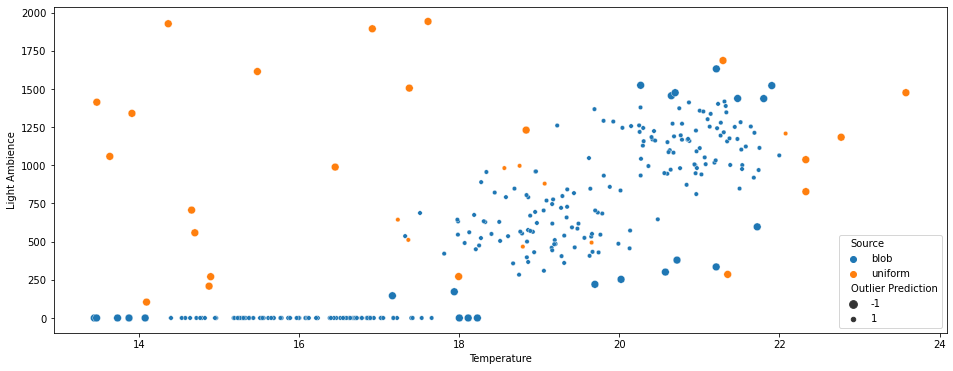

In [16]:
dataset_byoml = generate_dataset()

byoml_prediction = waylay.byoml.model.predict(MODEL_NAME, dataset_byoml[col_features])

dataset_byoml[col_predict] = byoml_prediction

plt.figure(figsize=(16, 6))
ax = sns.scatterplot(
    x=col_tmp, y=col_amb, hue=col_src, size=col_predict, sizes=[60,20], data=dataset_byoml
)

## Upload and test with a Data Query

In the example above we created a toy dataset, but in real world use cases, you probably want to use data already available in Waylay. 

Let's simulate that by first uploading 10 weeks of data and then use a dedicated Query to fetch the data.

Uploading the dataset above can also be done using the SDK, we will convert it to a timestamped dataset first:

In [17]:
data_until = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
upload_count= 10 * 7 * 24 

dataset_import = generate_dataset(upload_count)
data_until
index = pd.date_range(end=data_until, periods=upload_count, freq='1H')

dataset_import = dataset_import.set_index(index)
dataset_import

,Temperature,Light Ambience,Source
2021-02-23 01:00:00,21.850488,1307.671894,blob
2021-02-23 02:00:00,18.887998,483.148014,blob
2021-02-23 03:00:00,14.924644,0.000000,blob
2021-02-23 04:00:00,20.751057,1197.096831,blob
2021-02-23 05:00:00,20.302859,1126.843075,blob
...,...,...,...
2021-05-03 20:00:00,15.869128,0.000000,blob
2021-05-03 21:00:00,21.007432,1124.770686,blob
2021-05-03 22:00:00,22.396245,804.935116,uniform
2021-05-03 23:00:00,18.340542,471.314607,blob


Timeseries data in waylay is normally associated with a _resource_. It is the entity that contains descriptions of the device (or other source) of IoT events. 

The `waylay.api.resource` actions let you manage these _resources.


In [18]:
resource_id = f'byoml-{MODEL_NAME}'
waylay.api.resource.update(resource_id, body={
    'id': resource_id,
    'name': resource_id
})

{'id': 'byoml-tutorial-2021-05-04-0539',
 'name': 'byoml-tutorial-2021-05-04-0539'}

Now let's import this data into Waylay using the `waylay.timeseries.etl_tool` for bulk timeseries uploads.

In [19]:
etl_import = waylay.timeseries.etl_tool.prepare_import(
    dataset_import,
    name= f'byoml-{MODEL_NAME}',
    resource=resource_id,
    timestamp_timezone='UTC'
)
etl_import = waylay.timeseries.etl_tool.initiate_import(etl_import)

100%|██████████| 3.00/3.00 [00:00<00:00, 53.9series/s]


Uploading content to etl-import/upload/byoml-tutorial-2021-05-04-0539-timeseries.csv.gz ...
... done.


Importing data this way is an asynchronous process. 

Use `waylay.timeseries.etl_tool.check_import` to check on
the progress before continuing.

In [20]:
from IPython.display import HTML

for attempt in Retrying(stop=stop_after_attempt(10),wait=wait_fixed(10)):
    with attempt:

        import_job = waylay.timeseries.etl_tool.check_import(etl_import)

        display(HTML(import_job.to_html()))

        if import_job.status != 'done':
            raise TryAgain

In [21]:
from IPython.display import HTML

import_job = waylay.timeseries.etl_tool.check_import(etl_import)
display(HTML(import_job.to_html()))

After uploading the dataset, we can use it in a Query. 

Let's query the last 7 days directly: 

In [22]:
query_name=f"query-{resource_id}"
query = {
    "window": "P7D",
    "data" : [
        {'resource': resource_id, 'metric': column}
        for column in col_features
    ]
}
waylay.analytics.query.execute(body=query)

resource                  byoml-tutorial-2021-05-04-0539               
metric                                       Temperature Light Ambience
timestamp                                                              
2021-04-27 10:00:00+00:00                      15.031563       0.000000
2021-04-27 11:00:00+00:00                      14.038116       0.000000
2021-04-27 12:00:00+00:00                      16.055472       0.000000
2021-04-27 13:00:00+00:00                      17.800558       0.000000
2021-04-27 14:00:00+00:00                      19.049043     957.917103
...                                                  ...            ...
2021-05-03 20:00:00+00:00                      15.869128       0.000000
2021-05-03 21:00:00+00:00                      21.007432    1124.770686
2021-05-03 22:00:00+00:00                      22.396245     804.935116
2021-05-03 23:00:00+00:00                      18.340542     471.314607
2021-05-04 00:00:00+00:00                      15.879586       0.000000

[159 rows x 2 columns]

We'll save this query under a name, so that we can reuse it. 

In [23]:
query_name=f"query-{resource_id}"
waylay.analytics.query.replace(query_name, body={
    'query': query
})
waylay.analytics.query.get(query_name)

{'data': [{'metric': 'Temperature',
   'resource': 'byoml-tutorial-2021-05-04-0539'},
  {'metric': 'Light Ambience', 'resource': 'byoml-tutorial-2021-05-04-0539'}],
 'window': 'P7D'}

You can still override the properties of the query when executing them with `waylay.analytics.query.data`.

<AxesSubplot:xlabel='timestamp'>

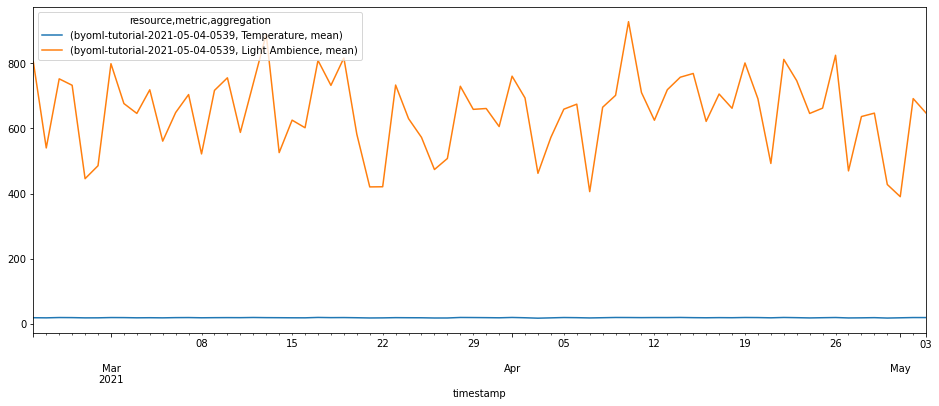

In [24]:
waylay.analytics.query.data(
    query_name, params={ 'window': 'P70D', 'aggregation': 'mean', 'freq': 'P1D' }
).plot(figsize=(16, 6))

Let's use this to select a new training set and validation set for our model

In [25]:
data_previous_month = waylay.analytics.query.data(query_name, params={'window': 'P30D', 'until': '-P30D'})
data_previous_month

resource                  byoml-tutorial-2021-05-04-0539               
metric                                       Temperature Light Ambience
timestamp                                                              
2021-03-05 10:00:00+00:00                      16.437124       0.000000
2021-03-05 11:00:00+00:00                      20.374248    1104.512718
2021-03-05 12:00:00+00:00                      18.826144     875.765658
2021-03-05 13:00:00+00:00                      21.666029    1085.336651
2021-03-05 14:00:00+00:00                      18.246134     637.700436
...                                                  ...            ...
2021-04-04 05:00:00+00:00                      18.643811    1108.128401
2021-04-04 06:00:00+00:00                      20.976032    1219.029741
2021-04-04 07:00:00+00:00                      14.966826       0.000000
2021-04-04 08:00:00+00:00                      20.946594    1448.978614
2021-04-04 09:00:00+00:00                      19.023926     649.594896

[720 rows x 2 columns]

In [26]:
data_last_week = waylay.analytics.query.data(query_name, params={ 'until': '-P1D' })
data_last_week

resource                  byoml-tutorial-2021-05-04-0539               
metric                                       Temperature Light Ambience
timestamp                                                              
2021-04-26 10:00:00+00:00                      19.290168     678.483337
2021-04-26 11:00:00+00:00                      16.749140       0.000000
2021-04-26 12:00:00+00:00                      19.640513     420.131423
2021-04-26 13:00:00+00:00                      20.469787    1182.672132
2021-04-26 14:00:00+00:00                      17.730809     660.012782
...                                                  ...            ...
2021-05-03 05:00:00+00:00                      20.993095    1376.201504
2021-05-03 06:00:00+00:00                      21.688148    1238.092642
2021-05-03 07:00:00+00:00                      20.351116     952.934988
2021-05-03 08:00:00+00:00                      17.431480       0.000000
2021-05-03 09:00:00+00:00                      16.641145       0.000000

[168 rows x 2 columns]

We can now do the same as we did above, but now using data directly from Waylay, which will also help when we make a rule with this model and Query.

In [27]:
model = IsolationForest()
model.fit(data_previous_month)

waylay.byoml.model.replace(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='sklearn', 
    description='isolationforest example'
)

{'message': 'Model successfully uploaded'}

We can now grab other data to do the validation:

In [28]:
for attempt in Retrying(stop=stop_after_attempt(10),wait=wait_fixed(5)):
    with attempt:

        data_last_week_predict = waylay.byoml.model.predict(MODEL_NAME, data_last_week)

data_last_week_predict

array([ 1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1, -1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [29]:
data_last_week[col_predict] = waylay.byoml.model.predict(MODEL_NAME, data_last_week)
data_last_week

resource                  byoml-tutorial-2021-05-04-0539                 \
metric                                       Temperature Light Ambience   
timestamp                                                                 
2021-04-26 10:00:00+00:00                      19.290168     678.483337   
2021-04-26 11:00:00+00:00                      16.749140       0.000000   
2021-04-26 12:00:00+00:00                      19.640513     420.131423   
2021-04-26 13:00:00+00:00                      20.469787    1182.672132   
2021-04-26 14:00:00+00:00                      17.730809     660.012782   
...                                                  ...            ...   
2021-05-03 05:00:00+00:00                      20.993095    1376.201504   
2021-05-03 06:00:00+00:00                      21.688148    1238.092642   
2021-05-03 07:00:00+00:00                      20.351116     952.934988   
2021-05-03 08:00:00+00:00                      17.431480       0.000000   
2021-05-03 09:00:00+00:00                      16.641145       0.000000   

resource                  Outlier Prediction  
metric                                        
timestamp                                     
2021-04-26 10:00:00+00:00                  1  
2021-04-26 11:00:00+00:00                  1  
2021-04-26 12:00:00+00:00                  1  
2021-04-26 13:00:00+00:00                  1  
2021-04-26 14:00:00+00:00                  1  
...                                      ...  
2021-05-03 05:00:00+00:00                  1  
2021-05-03 06:00:00+00:00                  1  
2021-05-03 07:00:00+00:00                  1  
2021-05-03 08:00:00+00:00                  1  
2021-05-03 09:00:00+00:00                  1  

[168 rows x 3 columns]

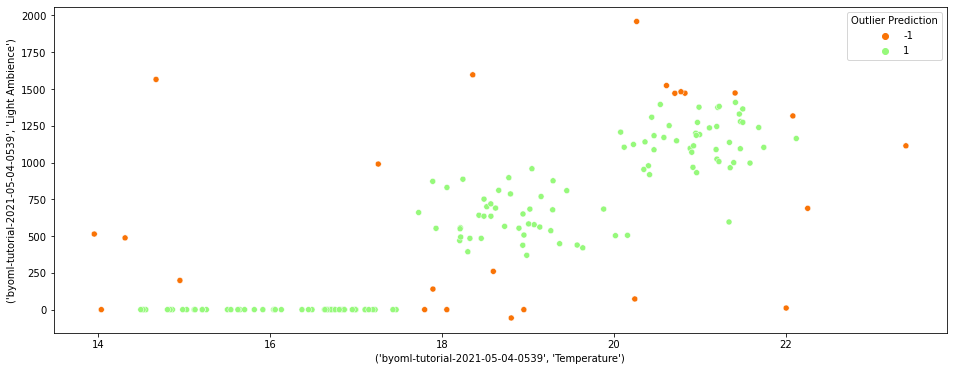

In [30]:
plt.figure(figsize=(16, 6))
cols = data_last_week.columns
ax = sns.scatterplot(
    x=(resource_id, col_tmp),
    y=(resource_id, col_amb),
    hue=col_predict, 
    palette=['xkcd:orange','xkcd:light green'], 
    data=data_last_week
)

#### Cleanup
We delete the entities that were created on the Waylay Platform
* the byoml model
* the query definition
* the waylay resource and its associated data

In [31]:
pd.DataFrame(
    index=['model','resource','query'], 
    data=[MODEL_NAME,resource_id,query_name], 
    columns=['id']
)

,id
model,tutorial-2021-05-04-0539
resource,byoml-tutorial-2021-05-04-0539
query,query-byoml-tutorial-2021-05-04-0539


In [32]:
waylay.analytics.query.remove(query_name)
waylay.api.resource.remove(resource_id)
waylay.byoml.model.remove(MODEL_NAME)

{'message': 'Model successfully deleted'}